In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sb
import os
import progressbar
import openpyxl as xl
import statsmodels.tools as tools

In [29]:
data = pd.read_excel('dane.xlsx')
data.set_index(['Year'], inplace = True)
data.head()

,GST,C02,World_pop,OHC,Sea_level,Surf_temp
Year,,,,,,
1960,-0.03,9387.010408,3.021529e+09,-1.678233,4.503937,13.758788
1961,0.06,9415.042136,3.062769e+09,-2.351233,4.748031,13.834421
1962,0.03,9747.287164,3.117373e+09,-1.311233,4.543307,13.773865
1963,0.05,10266.772214,3.184063e+09,-2.508233,4.480315,13.810860
1964,-0.20,10824.466098,3.251253e+09,-3.357233,4.169291,13.598911


# wykres danych

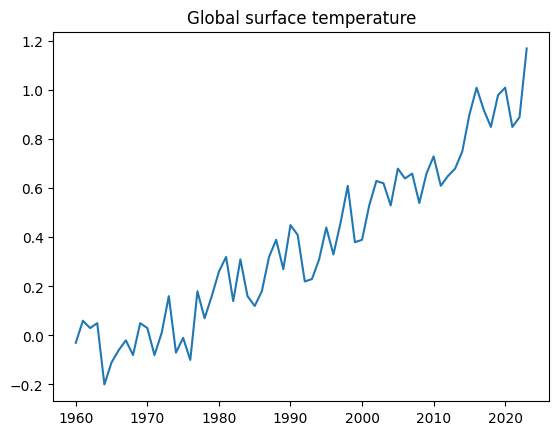

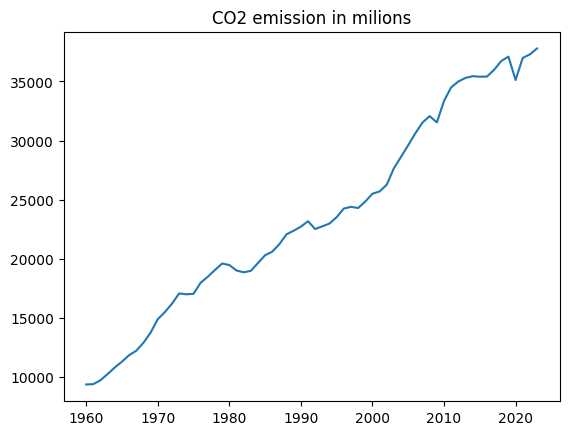

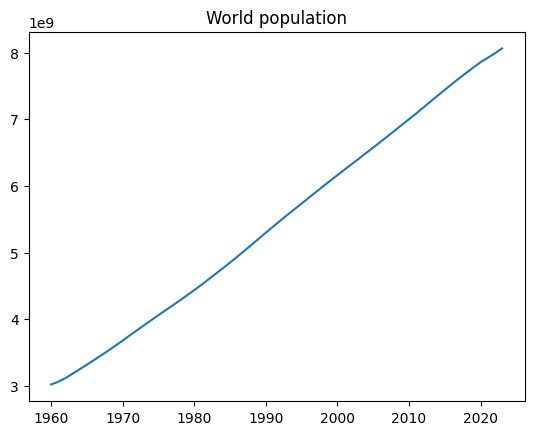

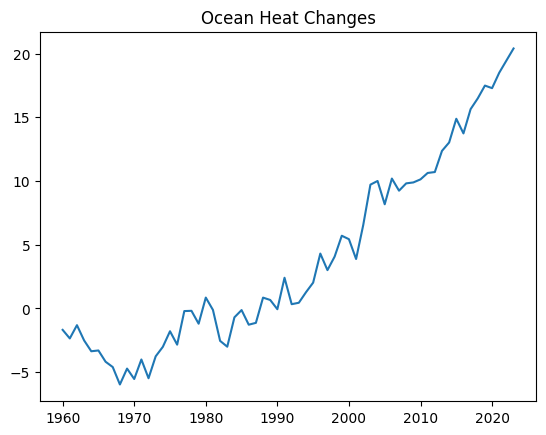

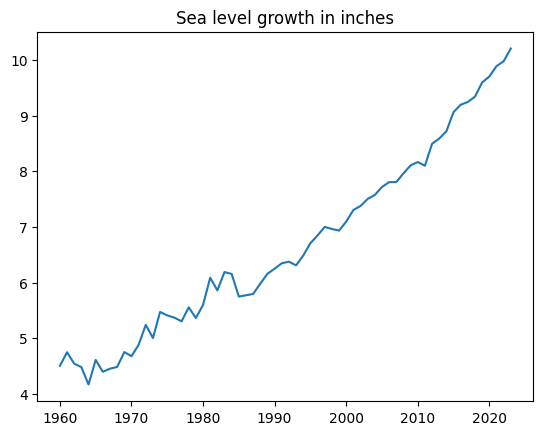

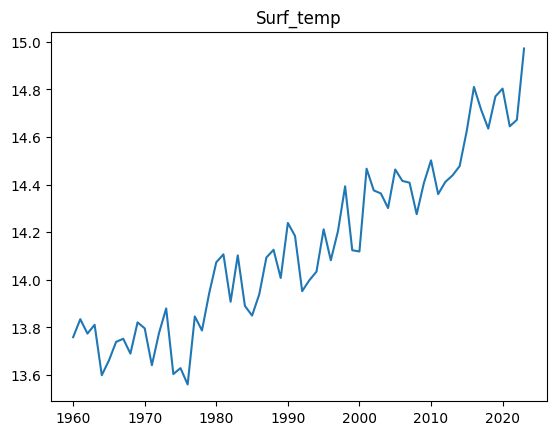

In [51]:
plt.plot(data['GST'])
plt.title('Global surface temperature')
plt.show()

plt.plot(data['C02'])
plt.title('CO2 emission in milions')
plt.show()

plt.plot(data['World_pop'])
plt.title('World population')
plt.show()

plt.plot(data['OHC'])
plt.title('Ocean Heat Changes')
plt.show()

plt.plot(data['Sea_level'])
plt.title('Sea level growth in inches')
plt.show()

plt.plot(data['Surf_temp'])
plt.title('Surf_temp')
plt.show()

# model liniowy ze wszystkimi zmiennymi

In [52]:
y = data[['GST']]  
x0 = pd.DataFrame(np.ones(y.shape), index = data.index, columns = ['const'])
X = pd.concat([x0, data[['GST', 'C02','World_pop','OHC','Sea_level','Surf_temp']]], axis = 1)
import math
model = sm.OLS(y, X).fit()     # <-- obiekt wyników; istnieje jeszcze obiekt modelu; obiekt wyników daje nam .fit(), bez tego byłby obiekt modelu
print(model.params)
print(model.cov_params())      # macierz kowariancji oszacowanych parametrów
model.summary()

const       -1.811847e-06
GST          1.000000e+00
C02         -4.525034e-12
World_pop   -5.855080e-17
OHC          1.214306e-16
Sea_level   -2.359224e-16
Surf_temp    4.440892e-16
dtype: float64
                  const           GST           C02     World_pop  \
const      1.269212e-08  1.077811e-09 -8.875029e-15  2.642855e-20   
GST        1.077811e-09  1.012385e-10 -6.663456e-16  1.101410e-21   
C02       -8.875029e-15 -6.663456e-16  6.724338e-20 -3.030099e-25   
World_pop  2.642855e-20  1.101410e-21 -3.030099e-25  2.594357e-30   
OHC       -7.637269e-13 -2.175734e-13  8.764445e-19  4.961711e-23   
Sea_level -2.726910e-12 -9.658909e-13 -7.115698e-17 -8.617832e-22   
Surf_temp -9.204225e-10 -7.773847e-11  6.834560e-16 -2.000125e-21   

                    OHC     Sea_level     Surf_temp  
const     -7.637269e-13 -2.726910e-12 -9.204225e-10  
GST       -2.175734e-13 -9.658909e-13 -7.773847e-11  
C02        8.764445e-19 -7.115698e-17  6.834560e-16  
World_pop  4.961711e-23 -8.617832e

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GST   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.364e+11
Date:                Thu, 22 May 2025   Prob (F-statistic):          2.35e-294
Time:                        02:30:57   Log-Likelihood:                 744.05
No. Observations:                  64   AIC:                            -1474.
Df Residuals:                      57   BIC:                            -1459.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.812e-06      0.000     -0.016      0.987      -0.000       0.000
GST            1.0000   1.01e-05   9.94e+04      0.000       1.000       1.000
C02        -4.525e-12   2.59e-10     -0.017      0.986   -5.24e-10    5.15e-10
World_pop  -5.855e-17   1.61e-15     -0.036      0.971   -3.28e-15    3.17e-15
OHC         1.214e-16   1.76e-07    6.9e-10      1.000   -3.52e-07    3.52e-07
Sea_level  -2.359e-16   1.45e-06  -1.63e-10      1.000    -2.9e-06     2.9e-06
Surf_temp   4.441e-16   8.18e-06   5.43e-11      1.000   -1.64e-05    1.64e-05
==============================================================================
Omnibus:                        3.990   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.136   Jarque-Bera (JB):                2.295
Skew:                          -0.224   Prob(JB):                        0.317
Kurtosis:                       2.188   Cond. No.                     2.24e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.24e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# model liniowy z y jako surf_temp (bez GST i OHC)

In [53]:
data2 = pd.read_excel('dane2.xlsx')
data2.set_index(['Year'], inplace = True)
y2 = data2[['Surf_temp']]  
x0_2 = pd.DataFrame(np.ones(y.shape), index = data2.index, columns = ['const'])
X2 = pd.concat([x0_2, data2[['Surf_temp','C02','World_pop','OHC','Sea_level']]], axis = 1)
import math
model = sm.OLS(y2, X2).fit()     
print(model.params)
print(model.cov_params())      
model.summary()

const       -1.458695e-06
Surf_temp    1.000000e+00
C02          1.343739e-12
World_pop    9.129341e-17
OHC          6.730727e-16
Sea_level   -6.661338e-16
dtype: float64
                  const     Surf_temp           C02     World_pop  \
const      6.835064e-11 -5.209886e-12 -9.998538e-17  8.254343e-22   
Surf_temp -5.209886e-12  4.052684e-13  9.644390e-18 -6.480902e-23   
C02       -9.998538e-17  9.644390e-18  3.528941e-21 -1.660456e-26   
World_pop  8.254343e-22 -6.480902e-23 -1.660456e-26  1.449794e-31   
OHC        8.716684e-14 -3.402305e-15 -3.119307e-20  2.918489e-24   
Sea_level  4.242204e-13 -5.705087e-14 -4.351807e-18 -4.779220e-23   

                    OHC     Sea_level  
const      8.716684e-14  4.242204e-13  
Surf_temp -3.402305e-15 -5.705087e-14  
C02       -3.119307e-20 -4.351807e-18  
World_pop  2.918489e-24 -4.779220e-23  
OHC        1.711921e-15 -9.119677e-15  
Sea_level -9.119677e-15  1.170281e-13  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Surf_temp   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.510e+12
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        02:30:57   Log-Likelihood:                 835.65
No. Observations:                  64   AIC:                            -1659.
Df Residuals:                      58   BIC:                            -1646.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.459e-06   8.27e-06     -0.176      0.861    -1.8e-05    1.51e-05
Surf_temp      1.0000   6.37e-07   1.57e+06      0.000       1.000       1.000
C02         1.344e-12   5.94e-11      0.023      0.982   -1.18e-10     1.2e-10
World_pop   9.129e-17   3.81e-16      0.240      0.811   -6.71e-16    8.53e-16
OHC         6.731e-16   4.14e-08   1.63e-08      1.000   -8.28e-08    8.28e-08
Sea_level  -6.661e-16   3.42e-07  -1.95e-09      1.000   -6.85e-07    6.85e-07
==============================================================================
Omnibus:                       19.399   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.195
Skew:                          -0.130   Prob(JB):                        0.123
Kurtosis:                       1.773   Cond. No.                     6.93e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.93e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""